In [30]:
%pip install statsmodels
%pip install imbalanced-learn

import numpy as np


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [31]:
import pandas as pd 


df1=pd.read_csv("ab_data.csv")
df2=pd.read_csv("countries.csv")

In [32]:
df1.head()

,user_id,timestamp,group,landing_page,converted
0,851104,11:48.6,control,old_page,0
1,804228,01:45.2,control,old_page,0
2,661590,55:06.2,treatment,new_page,0
3,853541,28:03.1,treatment,new_page,0
4,864975,52:26.2,control,old_page,1


In [33]:
df2.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [34]:
full_data=pd.merge(df1,df2,on='user_id',how='left')

<h1>"Data Overview"</h1>

In [35]:
full_data.head()

,user_id,timestamp,group,landing_page,converted,country
0,851104,11:48.6,control,old_page,0,US
1,804228,01:45.2,control,old_page,0,US
2,661590,55:06.2,treatment,new_page,0,US
3,853541,28:03.1,treatment,new_page,0,US
4,864975,52:26.2,control,old_page,1,US


In [36]:
full_data.describe()

,user_id,converted
count,294482.000000,294482.000000
mean,787973.348225,0.119658
std,91210.636700,0.324561
min,630000.000000,0.000000
25%,709032.250000,0.000000
50%,787931.500000,0.000000
75%,866910.750000,0.000000
max,945999.000000,1.000000


In [37]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294482 entries, 0 to 294481
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294482 non-null  int64 
 1   timestamp     294482 non-null  object
 2   group         294482 non-null  object
 3   landing_page  294482 non-null  object
 4   converted     294482 non-null  int64 
 5   country       294482 non-null  object
dtypes: int64(2), object(4)
memory usage: 13.5+ MB


<h1>"Exploratory Data Analysis (EDA)"</h1>

In [38]:
full_data.isnull().sum()


user_id         0
timestamp       0
group           0
landing_page    0
converted       0
country         0
dtype: int64

In [39]:
duplicates=full_data['user_id'].duplicated().sum()
print(duplicates)


3897


In [40]:
# Keep the first instance of each user_id
full_data_cleaned = full_data.drop_duplicates(subset='user_id', keep='first')


In [41]:
#calculating conversion rates for control and treatment groups
conversion_rates=full_data_cleaned.groupby('group')['converted'].mean()*100 #converting to percentage

In [42]:
print(conversion_rates)

group
control      12.029718
treatment    11.884172
Name: converted, dtype: float64


In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\chatu\AppData\Local\Temp\ipykernel_17272\481359630.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=conversion_rates.index,y=conversion_rates.values,palette='pastel')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


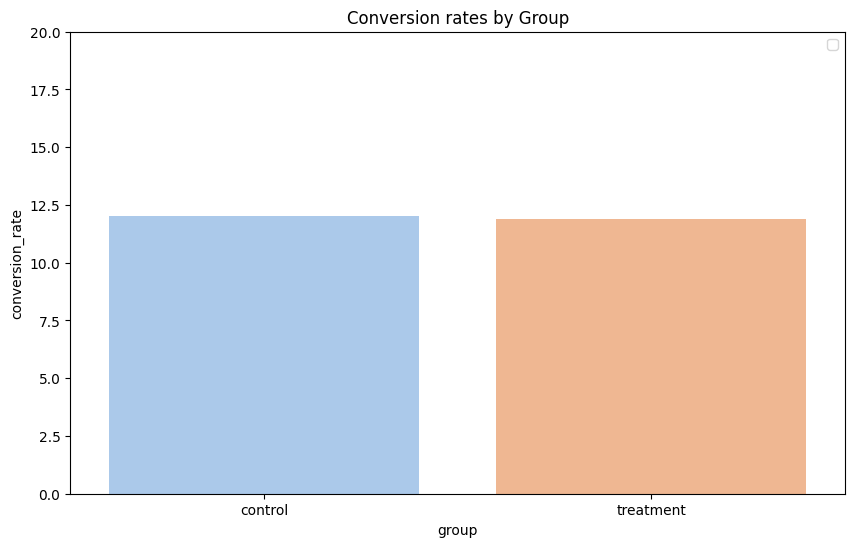

In [44]:
plt.figure(figsize=(10,6))
sns.barplot(x=conversion_rates.index,y=conversion_rates.values,palette='pastel')
plt.title("Conversion rates by Group")
plt.legend()
plt.xlabel('group')
plt.ylabel('conversion_rate')
plt.ylim(0,20)
plt.show()

Conversion Rates by Country:
country
CA    11.573212
UK    12.052549
US    11.950201
Name: converted, dtype: float64


C:\Users\chatu\AppData\Local\Temp\ipykernel_17272\1247513866.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=conversion_by_country.index, y=conversion_by_country.values, palette='viridis')


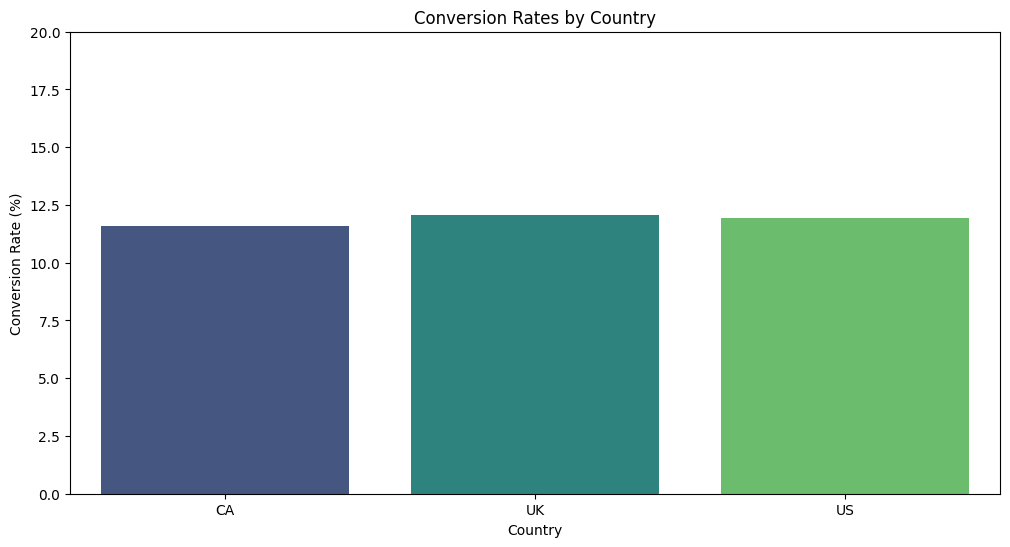

In [45]:
# Calculate conversion rates by country
conversion_by_country = full_data_cleaned.groupby('country')['converted'].mean() * 100
print(f"Conversion Rates by Country:\n{conversion_by_country}")

# Visualize conversion rates by country
plt.figure(figsize=(12, 6))
sns.barplot(x=conversion_by_country.index, y=conversion_by_country.values, palette='viridis')
plt.title('Conversion Rates by Country')
plt.xlabel('Country')
plt.ylabel('Conversion Rate (%)')
plt.ylim(0, 20)
plt.show()


In [46]:
# Count total conversions and non-conversions
total_conversions = full_data_cleaned['converted'].sum()
total_users = full_data_cleaned['user_id'].nunique()  # Unique users
conversion_rate = total_conversions / total_users * 100

print(f"Total Users: {total_users}")
print(f"Total Conversions: {total_conversions}")
print(f"Overall Conversion Rate: {conversion_rate:.2f}%")


Total Users: 290585
Total Conversions: 34745
Overall Conversion Rate: 11.96%


<h1><span style="background-color:yellow">
<span style="color:black">Hypothesis Testing (A/B Testing)</span></h1>

The primary goal of this project is to determine whether the new page (treatment) performs better than the old page (control) in terms of conversions. We will run a hypothesis test to determine if the observed differences in conversion rates between the two groups are statistically significant.

Step 1: Define Hypotheses
For an A/B test, we typically define the following hypotheses:

Null Hypothesis (H₀): There is no difference in conversion rates between the control (old page) and treatment (new page) groups.
Alternative Hypothesis (H₁): There is a difference in conversion rates between the control and treatment groups.
Mathematically:
H₀: 
𝑝 old = 𝑝 new
H₁: 
𝑝 old ≠𝑝 new
</span>

In [47]:
import statsmodels.api as sm

# Number of conversions and total users for each group
control_converted = full_data_cleaned[full_data_cleaned['group'] == 'control']['converted'].sum()
treatment_converted = full_data_cleaned[full_data_cleaned['group'] == 'treatment']['converted'].sum()

control_total = full_data_cleaned[full_data_cleaned['group'] == 'control'].shape[0]
treatment_total = full_data_cleaned[full_data_cleaned['group'] == 'treatment'].shape[0]

# Conversion rates for each group
control_rate = control_converted / control_total
treatment_rate = treatment_converted / treatment_total

# Perform the Z-test for proportions
count = np.array([control_converted, treatment_converted])  # Number of conversions in each group
nobs = np.array([control_total, treatment_total])  # Number of users in each group

z_stat, p_value = sm.stats.proportions_ztest(count, nobs)
print(f"Z-statistic: {z_stat}")
print(f"P-value: {p_value}")


Z-statistic: 1.2090677477177405
P-value: 0.22663681880712272


In [48]:
treatment_converted,control_converted

(17274, 17471)

<span style="color= : black">Interpret the Results
Z-statistic: This tells us how many standard deviations the difference in conversion rates is away from the null hypothesis. A larger Z-statistic indicates stronger evidence against the null hypothesis.

P-value: The p-value tells us the probability of observing a result as extreme as (or more extreme than) the one we got, assuming the null hypothesis is true.

If p-value < 0.05 (assuming a 5% significance level), we reject the null hypothesis and conclude that there is a statistically significant difference between the control and treatment groups.
If p-value > 0.05, we fail to reject the null hypothesis and conclude that the difference is not statistically significant.</span>

<span style="color:black">P-value = 0.227, which is much larger than the typical threshold of 0.05 (or 5% significance level).
Since the p-value is greater than 0.05, we fail to reject the null hypothesis.

<span style="background-color: yellow">Conclusion
Fail to reject the null hypothesis: The data does not provide sufficient evidence to conclude that the new page has a significantly different conversion rate compared to the old page.
Business Implication: Based on the current data, the company should not implement the new page yet because the difference in conversion rates between the old and new pages is not statistically significant.</span>



</span>

<set style="color:black"></style>

<set style="color:darkblack">
Effect Size Calculation:</style>
<set style="color:black">The effect size tells you the magnitude of the difference between the two groups, which helps in understanding the practical significance even if the result isn't statistically significant.



(Coehen's h)h=2×(arcsin(sqrt(p1))−arcsin(sqrt( p2)))
</style>

In [49]:
# Conversion rates for both groups
p1 = treatment_rate  # Treatment group conversion rate
p2 = control_rate    # Control group conversion rate

# Calculate Cohen's h
cohen_h = 2 * (np.arcsin(np.sqrt(p1)) - np.arcsin(np.sqrt(p2)))
print(f"Effect Size (Cohen's h): {cohen_h}")


Effect Size (Cohen's h): -0.0044858574019009945


In [50]:
treatment_rate,control_rate

(0.11884171637324308, 0.12029717968491792)

<set style="background-color:yellow">Cohen's h = -0.0045 indicates that the difference in conversion rates between the control and treatment groups is negligibly small.
The negative sign just means that the control group's conversion rate is slightly higher than the treatment group's, but the difference is so tiny that it's practically insignificant.</style>

<H1>"MACHINE LEARNING ANALSYIS"</H1>

In [51]:
print(full_data_cleaned['converted'].value_counts())


converted
0    255840
1     34745
Name: count, dtype: int64


<h3>"IMBALANCED DATA"</h3>
APPLYING SMOTE=SYNTHETIC MINORITY OVERSAMPLING TECHNIQUE

In [102]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

# Sample 20% of the full cleaned data
full_data_sampled = full_data_cleaned.sample(frac=0.5, random_state=42)

# Define the target variable (y) and the features (X)
X = full_data_sampled[['group', 'landing_page', 'country']]
y = full_data_sampled['converted']


# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Converting bool output to int type for smote to work properly
X_train_encoded = pd.get_dummies(X_train, drop_first=True)

X_train_encoded, X_test_encoded = X_train_encoded.align(X_test_encoded, join='left', axis=1, fill_value=0)

#Convert boolean columns to int
X_train_encoded['group_treatment'] = X_train_encoded['group_treatment'].astype(int)
X_train_encoded['landing_page_old_page'] = X_train_encoded['landing_page_old_page'].astype(int)
X_train_encoded['country_UK'] = X_train_encoded['country_UK'].astype(int)
X_train_encoded['country_US'] = X_train_encoded['country_US'].astype(int)




In [104]:
X_test_scaled.shape,X_train_encoded.shape,y_test.shape,y_train_encoded.shape,X.shape,full_data_sampled.shape

((29059, 4), (116233, 4), (29059,), (116233, 1), (145292, 3), (145292, 6))

In [72]:
X

,group,landing_page,country
283417,treatment,new_page,US
211371,control,old_page,US
219396,treatment,new_page,UK
234895,control,old_page,UK
181219,control,old_page,US
...,...,...,...
198942,control,old_page,US
184960,control,old_page,US
87485,treatment,new_page,UK
228967,control,old_page,US


In [74]:
y

283417    0
211371    0
219396    0
234895    0
181219    0
         ..
198942    0
184960    0
87485     0
228967    0
206303    1
Name: converted, Length: 145292, dtype: int64

In [84]:
X_train_encoded

,group_treatment,landing_page_old_page,country_UK,country_US
249488,0,1,0,1
18034,1,0,0,1
202128,1,0,1,0
155981,1,0,1,0
238245,1,0,0,1
...,...,...,...,...
59193,1,0,1,0
89710,0,1,0,1
201062,0,1,0,1
84142,0,1,0,1


In [103]:
# Apply SMOTE to address class imbalance
smote = SMOTE(random_state=42)
X_train_new, y_train_new = smote.fit_resample(X_train_encoded, y_train)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_new)
X_test_scaled = scaler.transform(X_test_encoded)

# Display the shape of the data to confirm the split
print(f"Training data shape: {X_train_new.shape}")
print(f"Testing data shape: {X_test.shape}")
print(f"New training labels shape: {y_train_new.shape}")

Training data shape: (204794, 4)
Testing data shape: (29059, 3)
New training labels shape: (204794,)


<h2>"Model Training"</h2>

In [53]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, auc


In [88]:
# Prepare models to evaluate
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=50, max_depth=10),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=50, max_depth=3,learning_rate=0.1),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss',n_estimators=50, max_depth=3),
}


In [55]:
from sklearn.model_selection import GridSearchCV

In [105]:
# Function to evaluate the model and store results
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None
    
    return accuracy, precision, recall, f1, roc_auc

# Hyperparameter tuning setup for different models
param_grids = {
    'Logistic Regression': {'C': [0.01, 0.1, 1, 10], 'solver': ['liblinear', 'lbfgs']},
    'Random Forest': {'n_estimators': [50, 100, 200], 'max_depth': [5, 10, 15], 'min_samples_split': [2, 5, 10]},
    'Gradient Boosting': {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1], 'max_depth': [3, 5]},
    'K-Nearest Neighbors': {'n_neighbors': [3, 5, 7, 9]},
    'XGBoost': {'n_estimators': [50, 100, 200], 'max_depth': [3, 5, 7], 'learning_rate': [0.01, 0.1]}
}
#To store the result
results_list=[]

# Evaluate each model and store the results in the DataFrame
for model_name, model in models.items():
    param_grid = param_grids.get(model_name, {})
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1', n_jobs=-1)
    grid_search.fit(X_train_scaled, y_train_new)
    
    best_model = grid_search.best_estimator_
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    
    # Try different thresholds (e.g., 0.3, 0.5, 0.7) to improve precision/recall balance
    thresholds = [0.3, 0.5, 0.7]
    for threshold in thresholds:
        accuracy, precision, recall, f1, roc_auc = evaluate_model(best_model, X_train_scaled, y_train_new, X_test_scaled, y_test, threshold)
        
        # Add to results DataFrame
        results_list.append({
            'Model': f"{model_name} (threshold={threshold})",
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1,
            'ROC-AUC': roc_auc
        })
# Create DataFrame from results
results_df = pd.DataFrame(results_list)

# Display the results
print(results_df)
results_df.style.background_gradient(cmap='viridis').format(precision=4)

Best parameters for Logistic Regression: {'C': 0.01, 'solver': 'liblinear'}
Best parameters for Random Forest: {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 100}
Best parameters for Gradient Boosting: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
Best parameters for K-Nearest Neighbors: {'n_neighbors': 3}


c:\Users\chatu\projects\mlprojects\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [01:50:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}


c:\Users\chatu\projects\mlprojects\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [01:50:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\chatu\projects\mlprojects\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [01:50:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


                                  Model  Accuracy  Precision    Recall  \
0   Logistic Regression (threshold=0.3)  0.503286   0.119214  0.496675   
1   Logistic Regression (threshold=0.5)  0.503286   0.119214  0.496675   
2   Logistic Regression (threshold=0.7)  0.503286   0.119214  0.496675   
3         Random Forest (threshold=0.3)  0.501153   0.117010  0.487424   
4         Random Forest (threshold=0.5)  0.501153   0.117010  0.487424   
5         Random Forest (threshold=0.7)  0.501153   0.117010  0.487424   
6     Gradient Boosting (threshold=0.3)  0.501153   0.117010  0.487424   
7     Gradient Boosting (threshold=0.5)  0.501153   0.117010  0.487424   
8     Gradient Boosting (threshold=0.7)  0.501153   0.117010  0.487424   
9   K-Nearest Neighbors (threshold=0.3)  0.880312   0.086957  0.000578   
10  K-Nearest Neighbors (threshold=0.5)  0.880312   0.086957  0.000578   
11  K-Nearest Neighbors (threshold=0.7)  0.880312   0.086957  0.000578   
12              XGBoost (threshold=0.3

,Model,Accuracy,Precision,Recall,F1 Score,ROC-AUC
0,Logistic Regression (threshold=0.3),0.5033,0.1192,0.4967,0.1923,0.5028
1,Logistic Regression (threshold=0.5),0.5033,0.1192,0.4967,0.1923,0.5028
2,Logistic Regression (threshold=0.7),0.5033,0.1192,0.4967,0.1923,0.5028
3,Random Forest (threshold=0.3),0.5012,0.1170,0.4874,0.1887,0.4962
4,Random Forest (threshold=0.5),0.5012,0.1170,0.4874,0.1887,0.4962
5,Random Forest (threshold=0.7),0.5012,0.1170,0.4874,0.1887,0.4964
6,Gradient Boosting (threshold=0.3),0.5012,0.1170,0.4874,0.1887,0.4962
7,Gradient Boosting (threshold=0.5),0.5012,0.1170,0.4874,0.1887,0.4962
8,Gradient Boosting (threshold=0.7),0.5012,0.1170,0.4874,0.1887,0.4962
9,K-Nearest Neighbors (threshold=0.3),0.8803,0.0870,0.0006,0.0011,0.5037


In [58]:
%pip install tensorflow


  You can safely remove it manually.


INFO: pip is looking at multiple versions of tensorflow to determine which version is compatible with other requirements. This could take a while.
   ---------------------------------------- 0.0/276.5 MB ? eta -:--:--
    --------------------------------------- 5.8/276.5 MB 29.4 MB/s eta 0:00:10
   - -------------------------------------- 10.0/276.5 MB 23.9 MB/s eta 0:00:12
   -- ------------------------------------- 14.4/276.5 MB 22.1 MB/s eta 0:00:12
   -- ------------------------------------- 18.4/276.5 MB 21.4 MB/s eta 0:00:13
   --- ------------------------------------ 22.8/276.5 MB 21.5 MB/s eta 0:00:12
   --- ------------------------------------ 27.0/276.5 MB 21.1 MB/s eta 0:00:12
   ---- ----------------------------------- 31.2/276.5 MB 20.8 MB/s eta 0:00:12
   ----- ---------------------------------- 35.4/276.5 MB 20.4 MB/s eta 0:00:12
   ----- ---------------------------------- 39.6/276.5 MB 20.5 MB/s eta 0:00:12
   ------ --------------------------------- 43.8/276.5 MB 20.3 

In [59]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

Epoch 1/50
2906/2906 [==============================] - 6s 2ms/step - loss: 0.3700 - accuracy: 0.8793 - val_loss: 0.3621 - val_accuracy: 0.8826
Epoch 2/50
2906/2906 [==============================] - 5s 2ms/step - loss: 0.3668 - accuracy: 0.8806 - val_loss: 0.3629 - val_accuracy: 0.8826
Epoch 3/50
2906/2906 [==============================] - 5s 2ms/step - loss: 0.3667 - accuracy: 0.8806 - val_loss: 0.3642 - val_accuracy: 0.8826
Epoch 4/50
2906/2906 [==============================] - 5s 2ms/step - loss: 0.3665 - accuracy: 0.8806 - val_loss: 0.3628 - val_accuracy: 0.8826
Epoch 5/50
2906/2906 [==============================] - 5s 2ms/step - loss: 0.3665 - accuracy: 0.8806 - val_loss: 0.3628 - val_accuracy: 0.8826
Epoch 6/50
2906/2906 [==============================] - 5s 2ms/step - loss: 0.3666 - accuracy: 0.8806 - val_loss: 0.3630 - val_accuracy: 0.8826
Epoch 7/50
2906/2906 [==============================] - 5s 2ms/step - loss: 0.3665 - accuracy: 0.8806 - val_loss: 0.3618 - val_accuracy:

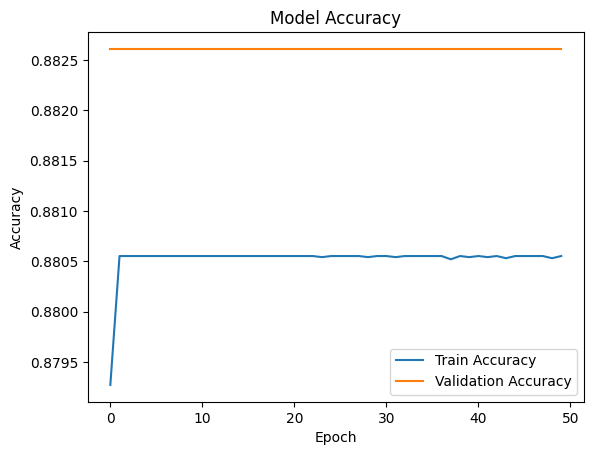

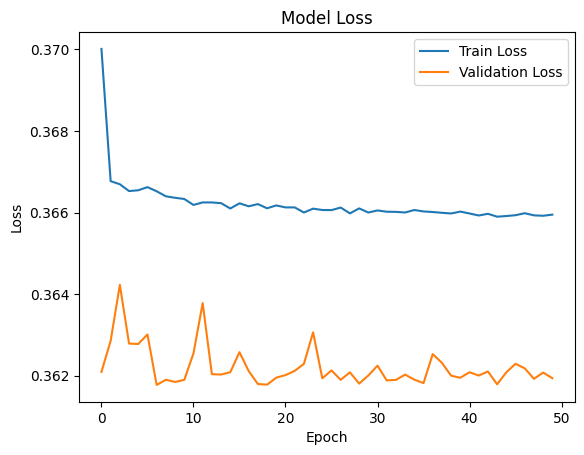

In [60]:
# Define the ANN model
model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),  # Input layer
    layers.Dense(32, activation='relu'),  # Hidden layer
    layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Make predictions
y_pred_proba = model.predict(X_test_scaled).flatten()  # Get probabilities
y_pred = (y_pred_proba > 0.5).astype(int)  # Convert probabilities to binary predictions

# Calculate metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC-AUC: {roc_auc:.4f}")

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [62]:
X_train_new.head()

,group_treatment,landing_page_old_page,country_UK,country_US
0,0,1,0,1
1,1,0,0,1
2,1,0,1,0
3,1,0,1,0
4,1,0,0,1
